# Categorical approach

In [1]:
# Libraries
using DataFrames;
using CSV;
using Random;
using Statistics;
using ScikitLearn;
using Flux.Losses;
using Flux;
using Plots;
using StatsPlots;
using Printf;

@sk_import impute: KNNImputer; # Imputation of missing values.
@sk_import svm: SVC;
@sk_import decomposition: PCA;
@sk_import tree: DecisionTreeClassifier;
@sk_import neighbors: KNeighborsClassifier;
@sk_import feature_selection: SelectKBest; # Feature Selection
@sk_import feature_selection: f_classif; # Used with SelectKBest

include("utils/fluxANNs.jl"); # for ANN training with Flux
include("utils/evaluation.jl"); # for confusion matrix calculatestimatorsion and cross validation set partitioning
include("utils/preprocessing.jl"); # for normalization, one-hot encoding, holdout division
include("utils/training.jl"); # for crossvalidation methodology
include("utils/visualizations.jl"); # for plots

# Set seed
Random.seed!(10);

[ Info: Running `conda install -y -c anaconda conda` in root environment


Channels:
 - anaconda
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/marcos/.julia/conda/3/x86_64

  added / updated specs:
    - conda


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2024.8.30~ --> anaconda/linux-64::certifi-2024.8.30-py312h06a4308_0 



Preparing transaction: done
Verifying transaction: done
Executing transaction: done


[ Info: Running `conda install -y -c conda-forge 'libstdcxx-ng>=3.4,<13.0'` in root environment


Channels:
 - conda-forge
 - anaconda
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/marcos/.julia/conda/3/x86_64

  added / updated specs:
    - libstdcxx-ng[version='>=3.4,<13.0']


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            anaconda/linux-64::certifi-2024.8.30-~ --> conda-forge/noarch::certifi-2024.8.30-pyhd8ed1ab_0 



Preparing transaction: done
Verifying transaction: done
Executing transaction: done


# Hold-out partition

In [2]:
# loading the dataset
support2 = CSV.read("datasets/support2_cleaned.csv", DataFrame, delim = ',');

# fate: 0 = recovery, 1 = death at home, 2 = death at the hospital
support2[:, "fate"] = support2[:,"death"] + support2[:,"hospdead"];
target_cols = ["death", "hospdead", "fate"];

trainIndex, testIndex = holdOut(nrow(support2), 0.2);

trainInputs = Array(support2[trainIndex, Not(target_cols)]);
testInputs = Array(support2[testIndex, Not(target_cols)]);

trainTargets = Array(support2[trainIndex, "fate"]);
testTargets = Array(support2[testIndex, "fate"]);

# Kfold
kFoldIndices = crossvalidation(trainTargets, 5);

# Imputation

In [3]:
imputer = KNNImputer(n_neighbors = 5);

trainInputs[:,1:32] = fit_transform!(imputer, trainInputs[:,1:32]);
testInputs[:,1:32] = imputer.transform(testInputs[:,1:32]);

# Visualizations

In [ ]:
meanTrain, stdTrain = calculateZeroMeanNormalizationParameters(trainInputs[:,1:32]);
numInputs = normalizeZeroMean!(trainInputs[:,1:32], (meanTrain, stdTrain));

plot_correlations(numInputs);
savefig("plots/correlations.png");

# Train PCA on training dataset.
pca = PCA(2);
pcaInputs = fit_transform!(pca, numInputs);

# Draw results
draw_results(pcaInputs, trainTargets; colors=[:green,:red,:blue],
 target_names=["Died", "Survived", "Died at hospital"]);
savefig("plots/pca.png");

- ANN

In [5]:
ANNparams = [Dict("topology" => [2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [2, 2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4, 4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8, 8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16, 16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1)]

models = [(:ANN, ANNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training ANN models:
Configuration 1: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [2], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(56 => 2, σ)   # 114 parameters
│   summary(x) = "56×5202 adjoint(::Matrix{Float64}) with eltype Float64"
└ @ Flux ~/.julia/packages/Flux/hiqg1/src/layers/stateless.jl:60


Accuracy:0.8105131151961332 (81.05%), stdDev:0.013321467185636607 (1.33%)
F1-Score:0.8085572406978938 (80.86%), stdDev:0.01320237198530748 (1.32%)

Configuration 2: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [4], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8103489019806969 (81.03%), stdDev:0.009850084475466045 (0.99%)
F1-Score:0.8095395639615004 (80.95%), stdDev:0.009745281195125355 (0.97%)

Configuration 3: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [8], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.806154563973976 (80.62%), stdDev:0.011728868997091565 (1.17%)
F1-Score:0.8056588711698971 (80.57%), stdDev:0.011652432903223877 (1.17%)

Configuration 4: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [16], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8074270969349581 (80.74%), stdDev:0.011046900189415

- SVM

In [6]:
SVMparams = [Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 1)]

models = [(:SVM, SVMparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training SVM models:
Configuration 1: Dict{String, Any}("C" => 0.1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8081877783239364 (80.82%), stdDev:0.011600659746975255 (1.16%)
F1-Score:0.80791945120062 (80.79%), stdDev:0.011598119731745276 (1.16%)

Configuration 2: Dict{String, Any}("C" => 1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8220266971967483 (82.20%), stdDev:0.01333045908698357 (1.33%)
F1-Score:0.821486058521331 (82.15%), stdDev:0.013307726376457343 (1.33%)

Configuration 3: Dict{String, Any}("C" => 0.1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.7818976622350401 (78.19%), stdDev:0.010895774782791703 (1.09%)
F1-Score:0.7814708774237384 (78.15%), stdDev:0.010636507890954385 (1.06%)

Configuration 4: Dict{String, Any}("C" => 1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.8052826390373988 (80.53%), stdDev:0.00941993552204245 (0.94%)
F1-Score:0.8049764895396653 (80.50%), stdDev:0.009357342

- DecisionTree

In [7]:
DTreeParams = [Dict("maxDepth" => 4), Dict("maxDepth" => 8), Dict("maxDepth" => 16),
                Dict("maxDepth" => 32), Dict("maxDepth" => 64), Dict("maxDepth" => 128)]

models = [(:DTree, DTreeParams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training DTree models:
Configuration 1: Dict("maxDepth" => 4)
Accuracy:0.8396077175901688 (83.96%), stdDev:0.01206070360013809 (1.21%)
F1-Score:0.836525922064823 (83.65%), stdDev:0.013014254527003673 (1.30%)

Configuration 2: Dict("maxDepth" => 8)
Accuracy:0.856489224752312 (85.65%), stdDev:0.0066241487538641584 (0.66%)
F1-Score:0.8553272508673551 (85.53%), stdDev:0.007137035864996404 (0.71%)

Configuration 3: Dict("maxDepth" => 16)
Accuracy:0.8279805551029276 (82.80%), stdDev:0.009134588748176778 (0.91%)
F1-Score:0.827970124926065 (82.80%), stdDev:0.009182285807294693 (0.92%)

Configuration 4: Dict("maxDepth" => 32)
Accuracy:0.8235516794693538 (82.36%), stdDev:0.005334893702530538 (0.53%)
F1-Score:0.8235233617428299 (82.35%), stdDev:0.005179210492153222 (0.52%)

Configuration 5: Dict("maxDepth" => 64)
Accuracy:0.8235516794693538 (82.36%), stdDev:0.005334893702530538 (0.53%)
F1-Score:0.8235233617428299 (82.35%), stdDev:0.005179210492153222 (0.52%)

Configuration 6: Dict("maxDepth" => 

- KNN

In [8]:
KNNparams = [Dict("k" => 3), Dict("k" => 6), Dict("k" => 12),
            Dict("k" => 24), Dict("k" => 48), Dict("k" => 96)]

models = [(:KNN, KNNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");

println(params);


Training KNN models:
Configuration 1: Dict("k" => 3)
Accuracy:

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7569d55bce00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

0.6980352345046559 (69.80%), stdDev:0.005734954210757029 (0.57%)
F1-Score:0.6985226536993591 (69.85%), stdDev:0.005775072580661025 (0.58%)

Configuration 2: Dict("k" => 6)
Accuracy:0.716851777426573

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7569d55bce00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

 (71.69%), stdDev:0.00973719559317901 (0.97%)
F1-Score:0.7176730575688073 (71.77%), stdDev:0.009655539057064748 (0.97%)

Configuration 3: Dict("k" => 12)
Accuracy:

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7569d55bce00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

0.7262629695475932 (72.63%), stdDev:0.00901894198390233 (0.90%)
F1-Score:0.7268299259499404 (72.68%), stdDev:0.00887604004204373 (0.89%)

Configuration 4: Dict("k" => 24)
Accuracy:0.7290318061942228

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7569d55bce00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

 (72.90%), stdDev:0.00580774721582268 (0.58%)
F1-Score:0.729433159888907 (72.94%), stdDev:0.005656483025339792 (0.57%)

Configuration 5: Dict("k" => 48)
Accuracy:

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7569d55bce00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

0.7359518396075126 (73.60%), stdDev:0.0069760408973776715 (0.70%)
F1-Score:0.7363605119298704 (73.64%), stdDev:0.006779593859781037 (0.68%)

Configuration 6: Dict("k" => 96)
Accuracy:0.730552764861696

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7569d55bce00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

 (73.06%), stdDev:0.00948682557557388 (0.95%)
F1-Score:0.730916995266626 (73.09%), stdDev:0.009306357374291056 (0.93%)

Best model is KNN with hyperparameters:
Dict("k" => 48)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7569d55bce00>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

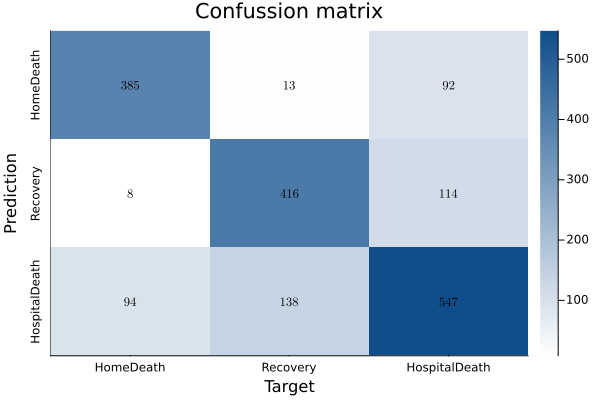

In [9]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# normalization and validation set computation if needed
valRatio = if modelType != :ANN 0. else params["validationRatio"] end
train, val, test = prepareDataForFitting(train, test, valRatio)

classes = unique(trainTargets)
matAndMetrics = fitAndConfusion(modelType, params, train, val, test, classes)
confMat = matAndMetrics[8]

class_map = Dict(0 => "Recovery", 1 => "HomeDeath", 2 => "HospitalDeath")
classNames = [class_map[class] for class in classes]
displayConfMat(confMat, classNames)

- Ensemble

In [14]:
@sk_import ensemble:StackingClassifier

# An ANN flux model cannot be included in a Scikit ensemble due to PyCall wrapping issues
estimators = [:KNN, :DTree, :SVM]
params = []
DTreeParams = Dict("maxDepth" => 8)
KNNparams = Dict("k" => 48)
SVMparams = Dict("C" => 1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)


params = Vector{Dict}([KNNparams, DTreeParams, SVMparams])

printCrossValOutput(trainClassEnsemble(estimators, params, (trainInputs, trainTargets),
                   crossvalidation(trainTargets, 5)));

Accuracy:0.8551050461218498

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7569c69fd440>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

 (85.51%), stdDev:0.006540930291134482 (0.65%)
F1-Score:0.8531990922720724 (85.32%), stdDev:0.007330670674111504 (0.73%)



Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7569c69ac0e0>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

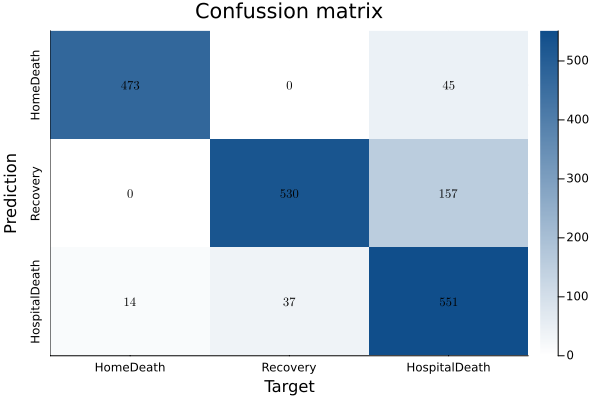

In [15]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# standardization is applied
trainNorm, _, testNorm = prepareDataForFitting(train, test)
ensemble = fitEnsemble(trainNorm, estimators, params)

classes = unique(trainTargets)
matAndMetrics = confusionMatrix(predict(ensemble, testNorm[1]), testTargets; weighted=true)
confMat = matAndMetrics[8]

class_map = Dict(0 => "Recovery", 1 => "HomeDeath", 2 => "HospitalDeath")
classNames = [class_map[class] for class in classes]
displayConfMat(confMat, classNames)